In [2]:
# user defined R installation
import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #path to your R installation
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import globalenv
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

from causaloptim_python import run_experiment, extract_prob_dict

import matplotlib.pyplot as plt
import seaborn as sns



# Load R packages
#igraph = importr('igraph')
causaloptim = importr('causaloptim')
base = importr('base')

#### Data Generation

In [256]:
df_loaded = pd.read_pickle("synthetic_ate_dataset.pkl")
df_loaded.head()
df_loaded.ATE_true.describe()

count    1100.000000
mean        0.500307
std         0.259662
min         0.050771
25%         0.276058
50%         0.499937
75%         0.724690
max         0.949870
Name: ATE_true, dtype: float64

In [274]:
sim = df_loaded.iloc[0]
df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})

In [275]:

graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
leftside = [1, 0, 0, 0]
latent   = [0, 0, 0, 1]
nvals    = [2, 2, 2, 2]
rlconnect = [0, 0, 0, 0]
monotone = [0, 0, 0, 0]

prob_dict = extract_prob_dict(df)
r_bounds = run_experiment(
    graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict
)
bound_lower = float(r_bounds[0][0])
bound_upper = float(r_bounds[1][0])

print(f"Seed: {sim['seed']}")
print(f"Coefficients: b_Z={sim['b_Z']}, b_U_X={sim['b_U_X']}, b_X_Y={sim['b_X_Y']}, b_U_Y={sim['b_U_Y']}")
print(f"True ATE: {sim['ATE_true']}")
print(f"Bounds: {bound_lower:.3f} — {bound_upper:.3f}")

Seed: 57006
Coefficients: b_Z=2.737257857041065, b_U_X=1.5551546948962143, b_X_Y=0.6720548733267528, b_U_Y=1.7774389104858237
True ATE: 0.05263147424100262
Bounds: 0.192 — 0.241


#### causaloptim

In [287]:
# Set seed and generate synthetic data in Python
np.random.seed(299128)
n = 5000
Z = np.random.binomial(1, 0.5, size=n)
U = np.random.binomial(1, 0.5, size=n)

# X ~ Z + U
logit_X = -1 + 1.5 * Z + 1.2 * U
p_X = 1 / (1 + np.exp(-logit_X))
X = np.random.binomial(1, p_X)

# Y ~ X + U
beta_X, beta_U = 1.0, 1.5
logit_Y = -0.5 + beta_X * X + beta_U * U
p_Y = 1 / (1 + np.exp(-logit_Y))
Y = np.random.binomial(1, p_Y)

df = pd.DataFrame({'Y': Y, 'X': X, 'Z': Z})

# Ground truth ATE
logit_Y1 = -0.5 + beta_X * 1 + beta_U * U
logit_Y0 = -0.5 + beta_X * 0 + beta_U * U
p_Y1 = 1 / (1 + np.exp(-logit_Y1))
p_Y0 = 1 / (1 + np.exp(-logit_Y0))
ATE_true = np.mean(p_Y1 - p_Y0)
print("True ATE:", ATE_true)


graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
leftside = [1, 0, 0, 0]
latent   = [0, 0, 0, 1]
nvals    = [2, 2, 2, 2]
rlconnect = [0, 0, 0, 0]
monotone = [0, 0, 0, 0]

prob_dict = extract_prob_dict(df)


bounds = run_experiment(graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict)
print("Bounds:", bounds)

True ATE: 0.19725243674534862
Bounds: (<rpy2.robjects.vectors.FloatVector object at 0x000001765E059450> [14]
R classes: ('numeric',)
[-0.117957], <rpy2.robjects.vectors.FloatVector object at 0x0000017657DCB6D0> [14]
R classes: ('numeric',)
[0.545062])


#### Varying Synthetic Data

In [283]:
def simulate_with_target_ate(
    n=5000,
    min_ate=0.05,
    max_ate=0.95,
    max_attempts=1000,
    coef_ranges=None,
    intercept_ranges=None,
    noise_std=0.5
):
    """
    Simulates data for binary treatment effect analysis.
    Fixes clustering by:
    - Using continuous U ~ N(0,1)
    - Adding Gaussian noise to logits

    Returns dict with true ATE and all coefficients.
    """
    if coef_ranges is None:
        coef_ranges = {
            'b_Z': (0.0, 3.0),
            'b_U_X': (0.0, 3.0),
            'b_X_Y': (0.5, 6.0),
            'b_U_Y': (0.0, 3.0)
        }
    if intercept_ranges is None:
        intercept_ranges = {
            'intercept_X': (-2.0, 2.0),
            'intercept_Y': (-4.0, 2.0)
        }

    for attempt in range(max_attempts):
        seed = np.random.randint(0, 1e6)
        np.random.seed(seed)

        # Coefficients
        b_Z = np.random.uniform(*coef_ranges['b_Z'])
        b_U_X = np.random.uniform(*coef_ranges['b_U_X'])
        b_X_Y = np.random.uniform(*coef_ranges['b_X_Y'])
        b_U_Y = np.random.uniform(*coef_ranges['b_U_Y'])

        intercept_X = np.random.uniform(*intercept_ranges['intercept_X'])
        intercept_Y = np.random.uniform(*intercept_ranges['intercept_Y'])

        # Generate continuous latent confounder
        Z = np.random.binomial(1, 0.5, size=n)
        U = np.random.normal(0, 1, size=n)

        # Generate treatment X
        logit_X = intercept_X + b_Z * Z + b_U_X * U
        p_X = 1 / (1 + np.exp(-logit_X))
        X = np.random.binomial(1, p_X)

        # Generate outcome Y with noise
        logit_Y = intercept_Y + b_X_Y * X + b_U_Y * U + np.random.normal(0, noise_std, size=n)
        p_Y = 1 / (1 + np.exp(-logit_Y))
        Y = np.random.binomial(1, p_Y)

        # Counterfactual outcomes with same noise structure
        logit_Y1 = intercept_Y + b_X_Y * 1 + b_U_Y * U + np.random.normal(0, noise_std, size=n)
        logit_Y0 = intercept_Y + b_X_Y * 0 + b_U_Y * U + np.random.normal(0, noise_std, size=n)
        p_Y1 = 1 / (1 + np.exp(-logit_Y1))
        p_Y0 = 1 / (1 + np.exp(-logit_Y0))
        ATE_true = np.mean(p_Y1 - p_Y0)

        if min_ate <= ATE_true <= max_ate:
            return {
                'seed': seed,
                'b_Z': b_Z,
                'b_U_X': b_U_X,
                'b_X_Y': b_X_Y,
                'b_U_Y': b_U_Y,
                'intercept_X': intercept_X,
                'intercept_Y': intercept_Y,
                'ATE_true': ATE_true,
                'Z': Z,
                'U': U,
                'X': X,
                'Y': Y
            }

    raise ValueError(f"Failed to generate ATE in range [{min_ate}, {max_ate}] after {max_attempts} attempts")

def simulate_uniform_ate_distribution(
    n=5000,
    n_bins=10,
    samples_per_bin=50,
    bin_range=(0.05, 0.95),
    simulate_kwargs=None,
    max_attempts=30000,
    verbose=True
):
    if simulate_kwargs is None:
        simulate_kwargs = {}

    bins = np.linspace(*bin_range, n_bins + 1)
    bin_counts = np.zeros(n_bins, dtype=int)
    data = []

    attempts = 0
    total_required = n_bins * samples_per_bin

    while sum(bin_counts) < total_required and attempts < max_attempts:
        sim = simulate_with_target_ate(n=n, min_ate=bin_range[0], max_ate=bin_range[1], **simulate_kwargs)
        ate = sim["ATE_true"]
        bin_idx = np.digitize(ate, bins) - 1

        if 0 <= bin_idx < n_bins and bin_counts[bin_idx] < samples_per_bin:
            bin_counts[bin_idx] += 1
            data.append(sim)

        attempts += 1

    if attempts >= max_attempts and sum(bin_counts) < total_required:
        print(f"⚠️ Warning: Only filled {sum(bin_counts)} / {total_required} samples after {attempts} attempts.")
        if verbose:
            for i in range(n_bins):
                print(f"  Bin {i} ({bins[i]:.2f}-{bins[i+1]:.2f}): {bin_counts[i]} samples")

    return data




sim_data = simulate_uniform_ate_distribution(
    n=5000,
    n_bins=5,
    samples_per_bin=50,
    simulate_kwargs={'noise_std': 1.0},  # more variation!
    verbose=True
)

df_uniform = pd.DataFrame(sim_data)
df_uniform.ATE_true.hist(bins=20)


KeyboardInterrupt: 

In [ ]:
results = []

n = 50000
graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
leftside = [1, 0, 0, 0]
latent   = [0, 0, 0, 1]
nvals    = [2, 2, 2, 2]
rlconnect = [0, 0, 0, 0]
monotone = [0, 0, 0, 0]

for i in range(500):
    # Simulate data with diverse ATEs
    sim = simulate_with_target_ate(n=n, min_ate=0.05, max_ate=0.95)

    # Create dataframe and get probabilities
    df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})
    prob_dict = extract_prob_dict(df)

    # Run causaloptim
    r_bounds = run_experiment(
        graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict
    )
    bound_lower = float(r_bounds[0][0])
    bound_upper = float(r_bounds[1][0])

    # Save result
    results.append({
        'seed': sim['seed'],
        'b_Z': sim['b_Z'],
        'b_U_X': sim['b_U_X'],
        'b_X_Y': sim['b_X_Y'],
        'b_U_Y': sim['b_U_Y'],
        'ATE_true': sim['ATE_true'],
        'bound_lower': bound_lower,
        'bound_upper': bound_upper
    })
df_results = pd.DataFrame(results)


#### Iteration testing area

In [ ]:
def simulate_deterministic_data_with_probabilistic_ate(
    n=5000,
    seed=None,
    intercept_X=-1.0,
    intercept_Y=-0.5,
    b_Z=1.5,
    b_U_X=1.2,
    b_X_Y=1.0,
    b_U_Y=1.5
):
    """
    Simulate deterministic (binary) data for causaloptim,
    but compute ATE from smooth logistic potential outcome probabilities.
    
    Returns:
        sim (dict): contains seed, coefficients, ATE_true, and arrays Z, U, X, Y
    """
    if seed is None:
        seed = np.random.randint(0, 1e6)
    np.random.seed(seed)
    # print(f"Seed: {seed}")

    # Binary variables
    Z = np.random.binomial(1, 0.5, size=n)
    U = np.random.binomial(1, 0.5, size=n)

    # Treatment assignment
    logit_X = intercept_X + b_Z * Z + b_U_X * U
    p_X = 1 / (1 + np.exp(-logit_X))
    X = np.random.binomial(1, p_X)

    # Deterministic outcome
    logit_Y = intercept_Y + b_X_Y * X + b_U_Y * U
    Y = (logit_Y > 0).astype(int)

    # Probabilistic potential outcomes
    logit_Y1 = intercept_Y + b_X_Y * 1 + b_U_Y * U
    logit_Y0 = intercept_Y + b_X_Y * 0 + b_U_Y * U
    p_Y1 = 1 / (1 + np.exp(-logit_Y1))
    p_Y0 = 1 / (1 + np.exp(-logit_Y0))
    ATE_true = np.mean(p_Y1 - p_Y0)

    return {
        'seed': seed,
        'intercept_X': intercept_X,
        'intercept_Y': intercept_Y,
        'b_Z': b_Z,
        'b_U_X': b_U_X,
        'b_X_Y': b_X_Y,
        'b_U_Y': b_U_Y,
        'ATE_true': ATE_true,
        'Z': Z,
        'U': U,
        'X': X,
        'Y': Y
    }
results = []
for i in range(100):
    sim = simulate_deterministic_data_with_probabilistic_ate(
        b_X_Y= i / 10,  # test impact
        intercept_Y= -5,
    )

    # DataFrame for causaloptim
    df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})
    prob_dict = extract_prob_dict(df)

    # Define Model
    graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
    leftside = [1, 0, 0, 0]
    latent   = [0, 0, 0, 1]
    nvals    = [2, 2, 2, 2]
    rlconnect = [0, 0, 0, 0]
    monotone = [0, 0, 0, 0]


    # Compute bounds
    bounds = run_experiment(
        graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict
    )
    bound_lower = float(bounds[0][0])
    bound_upper = float(bounds[1][0])

    bounds_valid = bound_lower <= sim['ATE_true'] <= bound_upper
    result = {
        'seed': sim['seed'],
        'b_Z': sim['b_Z'],
        'b_U_X': sim['b_U_X'],
        'b_X_Y': sim['b_X_Y'],
        'b_U_Y': sim['b_U_Y'],
        'ATE_true': sim['ATE_true'],
        'bound_lower': bound_lower,
        'bound_upper': bound_upper,
        'bounds_valid': bounds_valid
    }
    results.append(result)

df_results = pd.DataFrame(results)
## Plot ATE_true vs bounds
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='ATE_true', y='bound_lower', label='Lower Bound', alpha=0.6)
sns.scatterplot(data=df_results, x='ATE_true', y='bound_upper', label='Upper Bound', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.xlabel('True ATE')
plt.ylabel('Bounds')
plt.title('True ATE vs Bounds')
plt.legend()




Seed: 859458
Seed: 457279
Seed: 724588
Seed: 193886
Seed: 423724
Seed: 514108
Seed: 820417


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 697714
Seed: 945391


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 358782
Seed: 157438
Seed: 250714
Seed: 467114
Seed: 345673
Seed: 784648


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 146140
Seed: 192086


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 15676


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 704217
Seed: 150612
Seed: 304267


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 665400
Seed: 162096
Seed: 290340
Seed: 359216
Seed: 314178
Seed: 513938


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 344859


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 601400
Seed: 935776
Seed: 350566
Seed: 376737
Seed: 689847


Exception ignored from cffi callback <function _callback at 0x00000213A1CA6C00>:
Traceback (most recent call last):
  File "C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\rpy2\rinterface_lib\callbacks.py", line 336, in _callback
    @ffi_proxy.callback(ffi_proxy._callback_def,
    
KeyboardInterrupt: 


Seed: 719103
Seed: 173872
Seed: 925160


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



Seed: 394208
Seed: 295166
Seed: 775387
Seed: 258975
Seed: 493654
Seed: 676831
Seed: 848655
Seed: 99501
Seed: 782374
Seed: 344895
Seed: 315600
Seed: 574613
Seed: 231824
Seed: 231953
Seed: 725256
Seed: 220173
Seed: 825143
Seed: 954812
Seed: 416469
Seed: 5876
Seed: 557643
Seed: 436932


In [6]:
def diagnose_simulation_seed(seed, n=5000, **kwargs):
    print(f"\n🔍 Diagnosing simulation with seed = {seed}")
    sim = simulate_deterministic_data_with_probabilistic_ate(n=n, seed=seed, **kwargs)
    df = pd.DataFrame({'Z': sim['Z'], 'U': sim['U'], 'X': sim['X'], 'Y': sim['Y']})

    # Compute distributions
    px_z = df.groupby("Z")["X"].mean()
    py_z = df.groupby("Z")["Y"].mean()
    py_x = df.groupby("X")["Y"].mean()

    print("\n📊 Empirical means:")
    print(f"P(X=1 | Z=0): {px_z[0]:.3f}   P(X=1 | Z=1): {px_z[1]:.3f}")
    print(f"P(Y=1 | Z=0): {py_z[0]:.3f}   P(Y=1 | Z=1): {py_z[1]:.3f}")
    print(f"P(Y=1 | X=0): {py_x[0]:.3f}   P(Y=1 | X=1): {py_x[1]:.3f}")

    print("\n🧮 ATE_true:", round(sim['ATE_true'], 4))
    print("\n📐 Coefficients:")
    for key in ['b_Z', 'b_U_X', 'b_X_Y', 'b_U_Y', 'intercept_X', 'intercept_Y']:
        print(f"  {key}: {sim[key]:.4f}")

    # Visual plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    sns.barplot(x=px_z.index, y=px_z.values, ax=axs[0])
    axs[0].set_title("P(X=1 | Z)")
    axs[0].set_ylim(0, 1)

    sns.barplot(x=py_z.index, y=py_z.values, ax=axs[1])
    axs[1].set_title("P(Y=1 | Z)")
    axs[1].set_ylim(0, 1)

    sns.barplot(x=py_x.index, y=py_x.values, ax=axs[2])
    axs[2].set_title("P(Y=1 | X)")
    axs[2].set_ylim(0, 1)

    plt.suptitle(f"Diagnostic Summary for Seed {seed}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return sim, df


🔍 Diagnosing simulation with seed = 315623
Seed: 315623

📊 Empirical means:
P(X=1 | Z=0): 0.410   P(X=1 | Z=1): 0.761
P(Y=1 | Z=0): 0.643   P(Y=1 | Z=1): 0.824
P(Y=1 | X=0): 0.359   P(Y=1 | X=1): 1.000

🧮 ATE_true: 0.1976

📐 Coefficients:
  b_Z: 1.5000
  b_U_X: 1.2000
  b_X_Y: 1.0000
  b_U_Y: 1.5000
  intercept_X: -1.0000
  intercept_Y: -0.5000


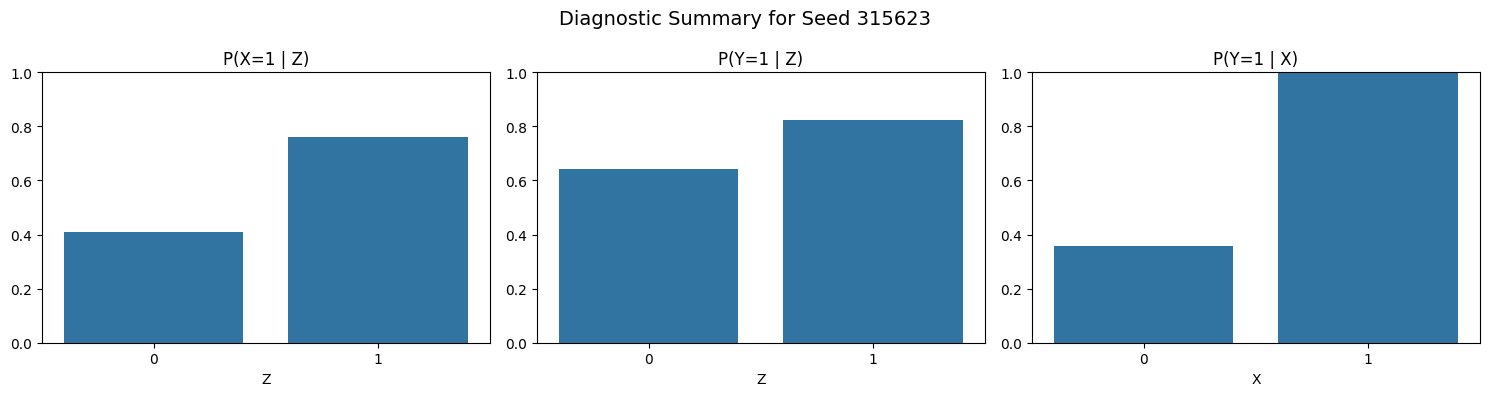

In [ ]:
sim, df = diagnose_simulation_seed(seed=930512) #out of bounds: 930512
